# 1. 라이브러리 Import 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import math

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6  # matlab 차트의 기본 크기를 지정

# 2. 함수 

- 기술적 분석툴 rolling statistics 사용
- 플로팅과 adfuller 메소드 사용하기 

In [2]:
def plot_rolling_statistics(timeseiries, window=12) :
    
    rolmean = timeseiries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseiries.rolling(window=window).std()    # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해본다.
    orig = plt.plot(timeseiries, color="blue", label="Original")
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    

- Statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
- 리턴한 결과를 정리하여 출력


In [3]:
def augmented_dickey_fuller_test(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')
    print('Result of Dickey-Fuller Test:')
    
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Ciritical value (%s)' % key] = value
    print(dfoutput)

In [4]:
def print_score(y_label, y_pred) :

    mse = mean_squared_error(np.exp(y_label), np.exp(y_pred))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(y_label), np.exp(y_pred))
    print('MAE: ', mae)

    rmse = math.sqrt(mse)
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(y_pred) - np.exp(y_label))/np.abs(np.exp(y_label)))
    print('MAPE: {:.2f}%'.format(mape*100))

# 3-1. 삼성전자 주식 분석 

### (1) 데이터 준비

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [6]:
# Time Series 생성
df = pd.read_csv('~/aiffel/stock_prediction/data/005930.KS.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...,...
245,2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
246,2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
247,2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920
248,2021-05-17,80800.0,80900.0,79200.0,79600.0,79600.000000,17740855


- Time series 추출


In [7]:
# time series 추출
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

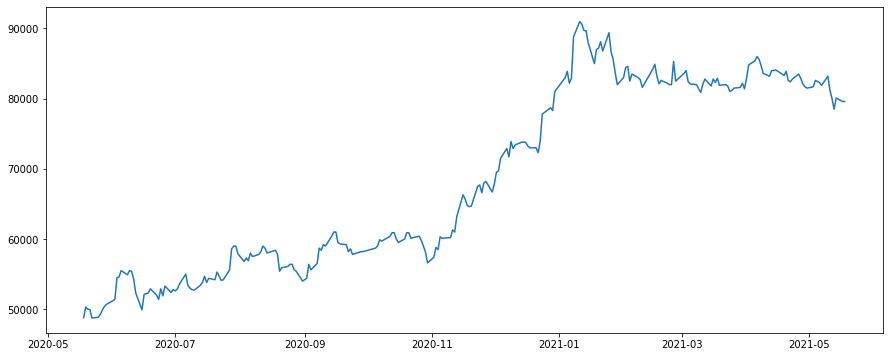

In [8]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)
plt.show()


- log 함수 변환

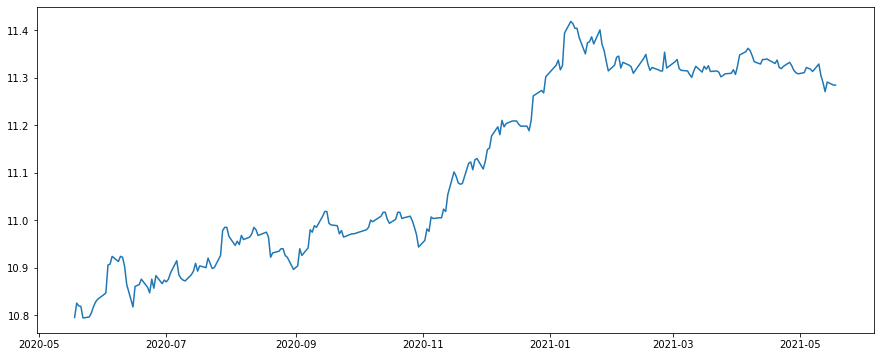

In [9]:
# 로그 변환 
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

### (2) 시계열 데이터 안정성 확인

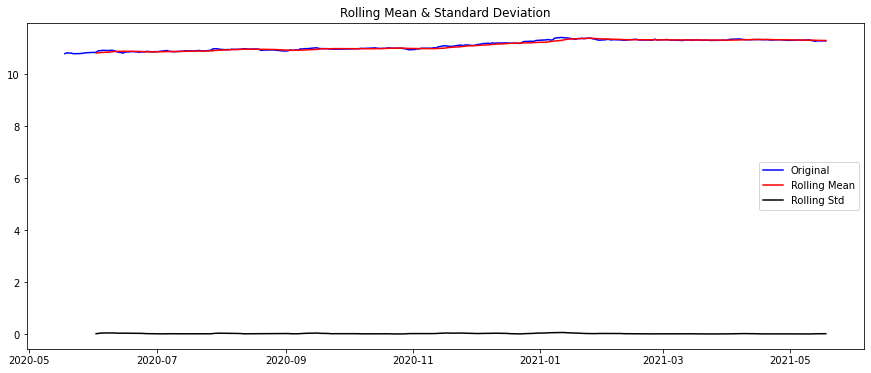

Result of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Ciritical value (1%)            -3.456888
Ciritical value (5%)            -2.873219
Ciritical value (10%)           -2.572994
dtype: float64


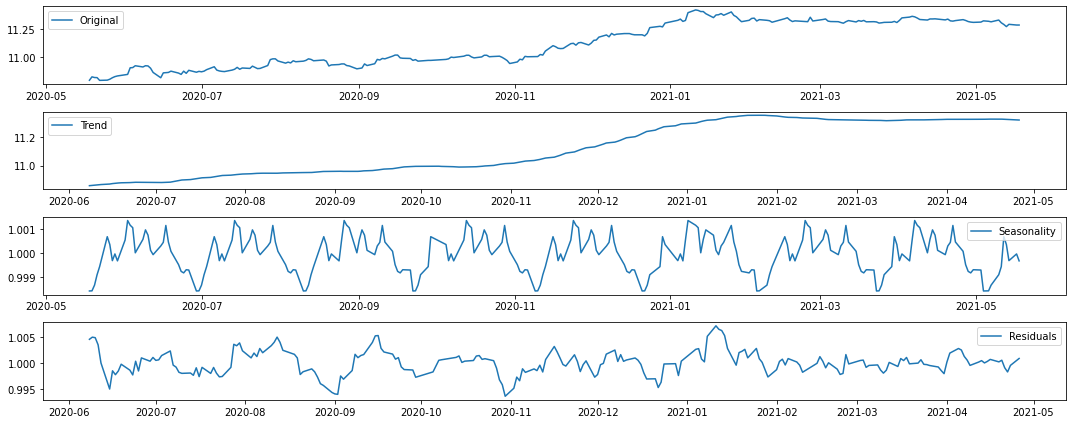

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

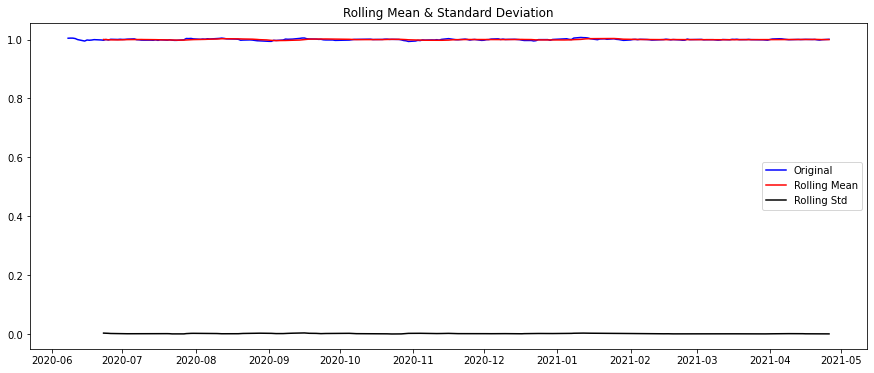

Result of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Ciritical value (1%)          -3.461879e+00
Ciritical value (5%)          -2.875404e+00
Ciritical value (10%)         -2.574159e+00
dtype: float64


In [11]:
# Residual 안정성 확인 
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### (3) 학습, 테스트 데이터셋 분리

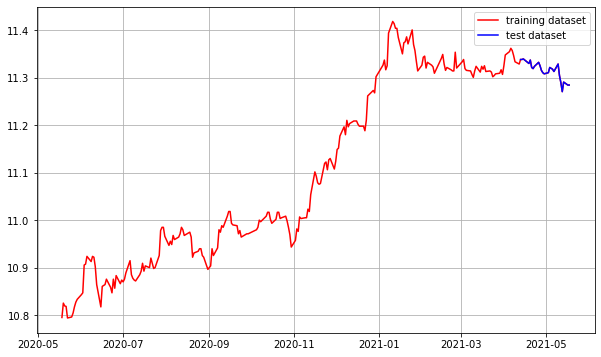

In [12]:

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### (4) 적정 ARIMA 모수 찾기 

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


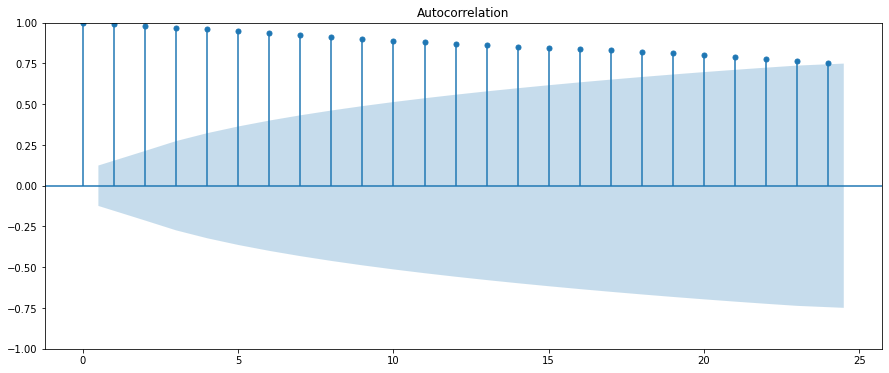

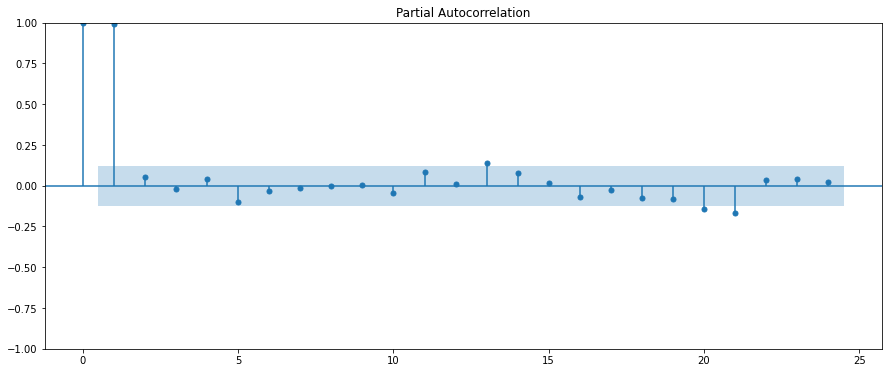

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Result of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Ciritical value (1%)          -3.456996e+00
Ciritical value (5%)          -2.873266e+00
Ciritical value (10%)         -2.573019e+00
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Ciritical value (1%)          -3.457894e+00
Ciritical value (5%)          -2.873659e+00
Ciritical value (10%)         -2.573229e+00
dtype: float64


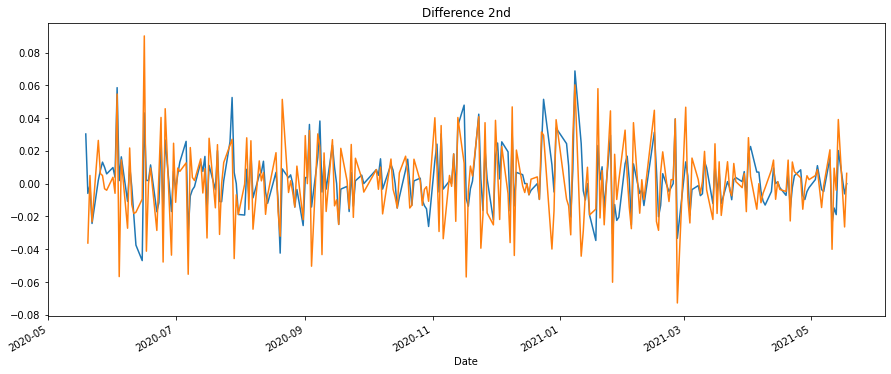

In [14]:

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### (5) ARIMA 모델 훈련과 테스트

In [15]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 05 May 2022   AIC                          -1156.722
Time:                        14:02:01   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

- 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


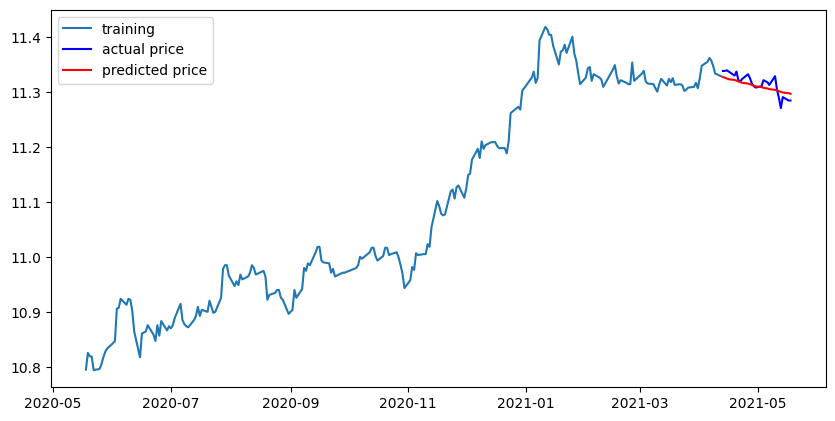

In [16]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


- 최종 예측 모델 정확도 측정 (MAPE)

In [17]:
print_score(test_data, fc)

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# 3-2. AT & T

### (1) 시계열 데이터 준비 



In [18]:
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/T.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()



Date
2021-05-05    24.191843
2021-05-06    24.478851
2021-05-07    24.290030
2021-05-10    24.645016
2021-05-11    24.365559
Name: Close, dtype: float64

In [19]:

# Time Series 생성
df = pd.read_csv('~/aiffel/stock_prediction/data/T.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-05,24.176737,24.305136,24.025681,24.191843,22.095184,41937965
1,2021-05-06,24.199396,24.486404,23.950151,24.478851,22.357319,38556072
2,2021-05-07,24.320242,24.441088,24.214502,24.290030,22.184862,38330065
3,2021-05-10,24.418428,24.848944,24.365559,24.645016,22.509081,54262286
4,2021-05-11,24.539274,24.675226,24.229607,24.365559,22.253845,44221335
...,...,...,...,...,...,...,...
249,2022-04-29,19.360001,19.370001,18.809999,18.860001,18.860001,70195400
250,2022-05-02,19.000000,19.389999,18.860001,19.120001,19.120001,67551600
251,2022-05-03,19.180000,19.680000,19.040001,19.330000,19.330000,62675300
252,2022-05-04,19.280001,19.980000,19.209999,19.950001,19.950001,60759200


In [20]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
ts = df['Close']
ts.head()

Date
2021-05-05    24.191843
2021-05-06    24.478851
2021-05-07    24.290030
2021-05-10    24.645016
2021-05-11    24.365559
Name: Close, dtype: float64

### (2) 각종 전처리 수행

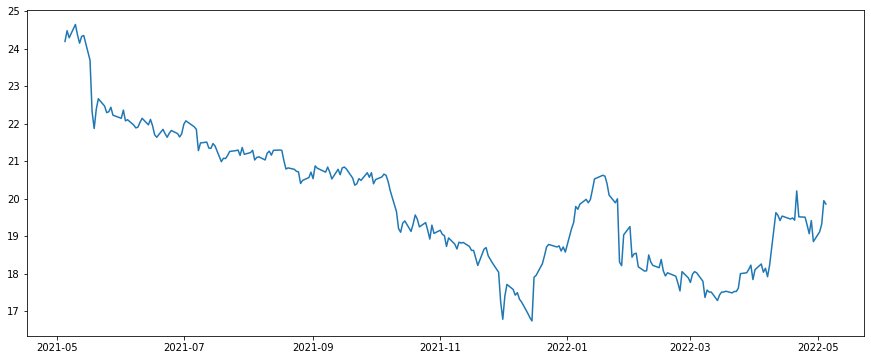

In [21]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)
plt.show()

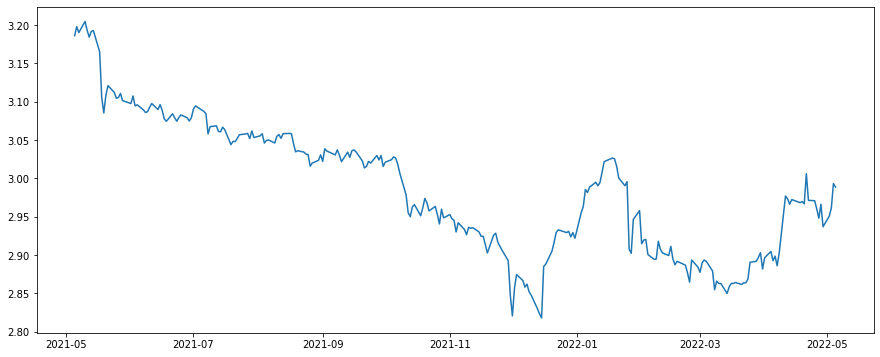

In [22]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

### (3) 시계열 안정성 분석

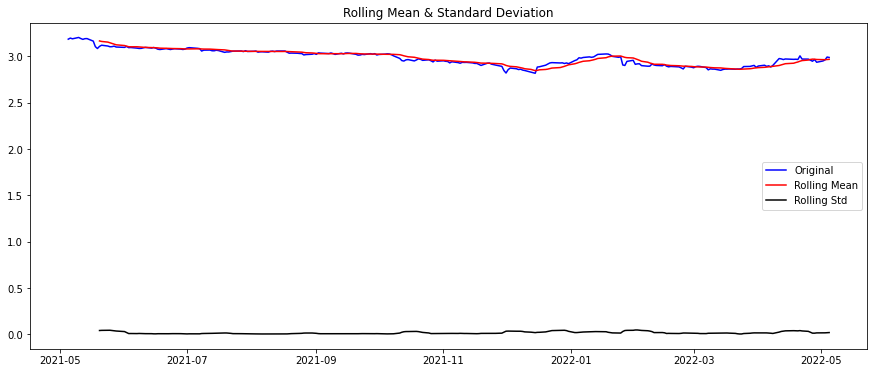

Result of Dickey-Fuller Test:
Test Statistic                  -2.383099
p-value                          0.146564
#Lags Used                       0.000000
Number of Observations Used    253.000000
Ciritical value (1%)            -3.456464
Ciritical value (5%)            -2.873033
Ciritical value (10%)           -2.572895
dtype: float64


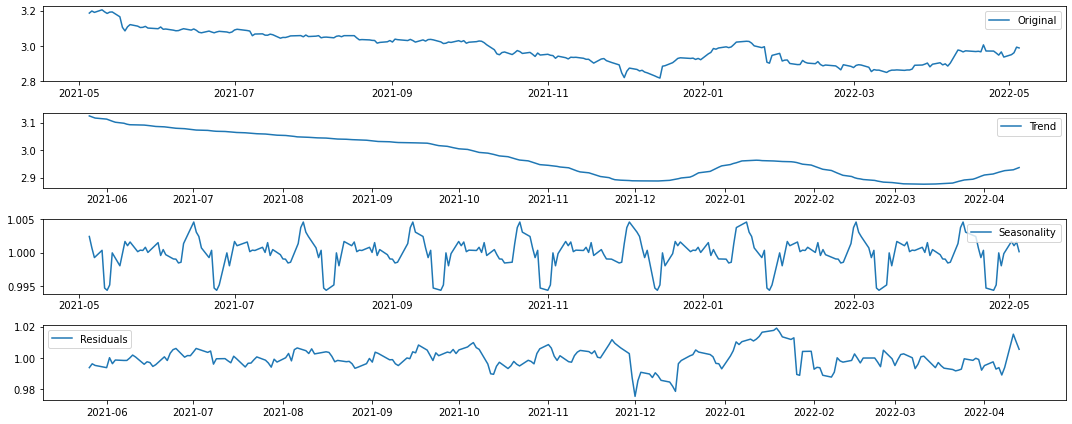

In [23]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

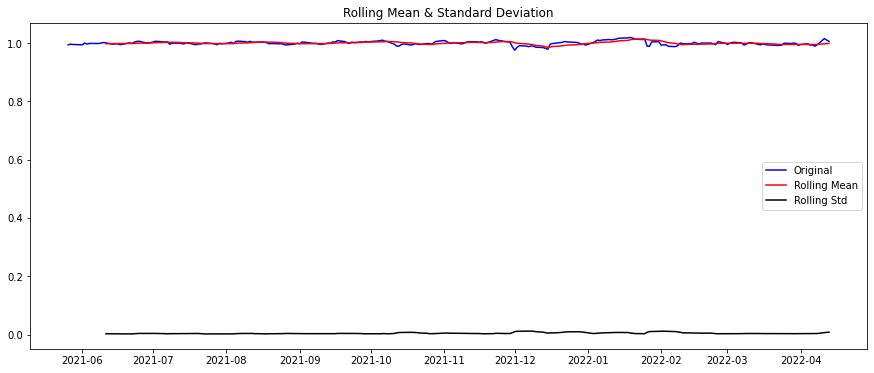

Result of Dickey-Fuller Test:
Test Statistic                  -4.414118
p-value                          0.000280
#Lags Used                       2.000000
Number of Observations Used    221.000000
Ciritical value (1%)            -3.460291
Ciritical value (5%)            -2.874709
Ciritical value (10%)           -2.573789
dtype: float64


In [24]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### (4) 학습, 테스트 데이터셋 생성

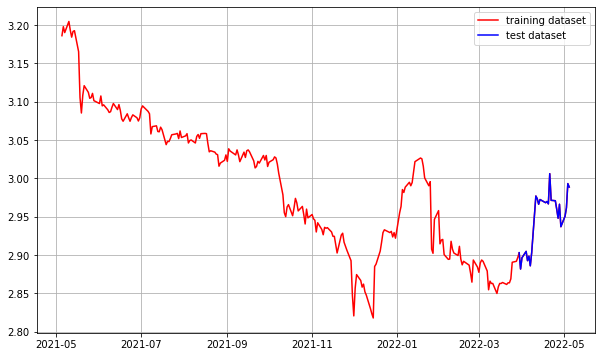

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### (5) 적정 ARIMA 모수 찾기 

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


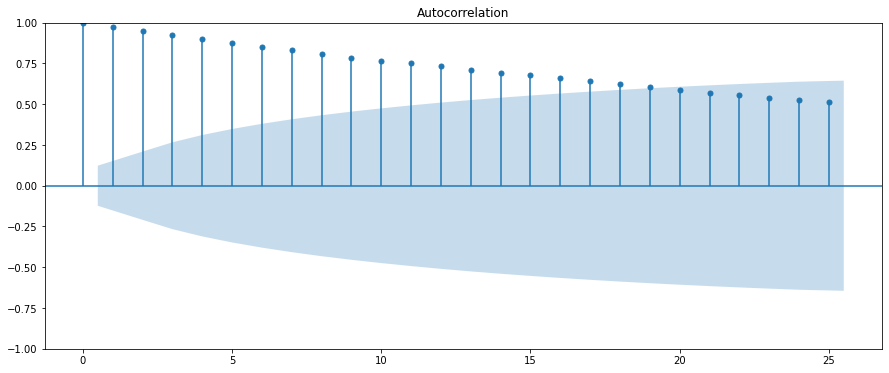

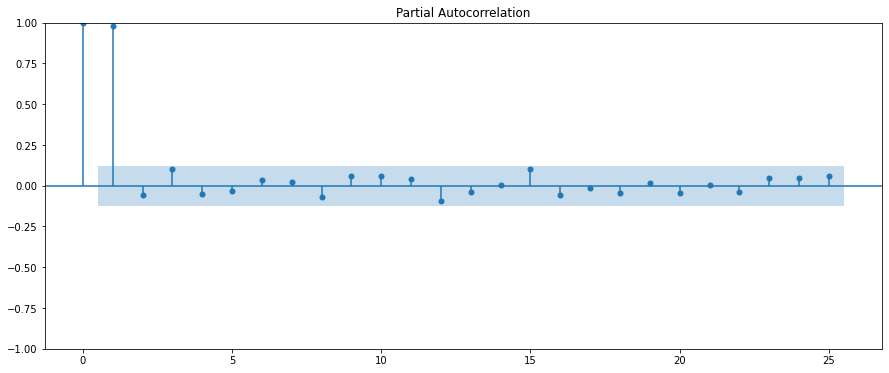

In [26]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Result of Dickey-Fuller Test:
Test Statistic                -1.274894e+01
p-value                        8.617919e-24
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Ciritical value (1%)          -3.456674e+00
Ciritical value (5%)          -2.873125e+00
Ciritical value (10%)         -2.572944e+00
dtype: float64


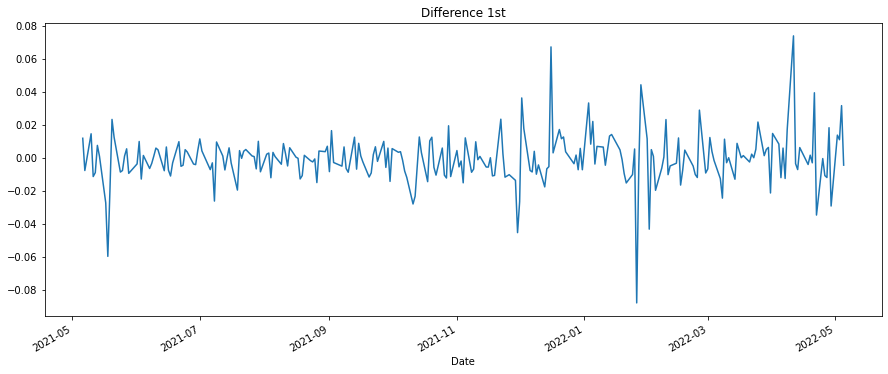

In [27]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### (6) ARIMA 모델 훈련 및 테스트


In [28]:
from statsmodels.tsa.arima.model import ARIMA

# Build and train model
# p, d, q
model = ARIMA(train_data, order=(1,0,0))
fitted_m = model.fit()

print('-'*30)

print(fitted_m.summary())

------------------------------
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 644.224
Date:                Thu, 05 May 2022   AIC                          -1282.447
Time:                        14:02:04   BIC                          -1272.159
Sample:                             0   HQIC                         -1278.297
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0167      0.069     43.780      0.000       2.882       3.152
ar.L1          0.9924      0.007    134.587      0.000       0.978       1.007
sigma2         0.0002

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


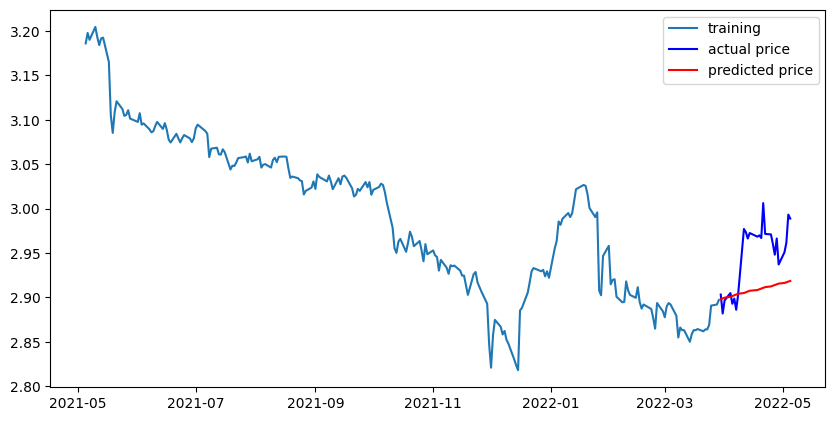

In [29]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()




In [30]:

print_score(test_data, fc)

MSE:  0.9055118343155593
MAE:  0.7970268496805427
RMSE:  0.9515838556404576
MAPE: 4.09%


# 3-3. GOOGLE 


### (1) 데이터 준비 


In [31]:
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2017-05-01    927.130005
2017-05-08    932.219971
2017-05-15    934.010010
2017-05-22    971.469971
2017-05-29    975.599976
Name: Close, dtype: float64

In [32]:

# Time Series 생성
df = pd.read_csv('~/aiffel/stock_prediction/data/GOOG.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-01,926.070007,935.929993,924.590027,927.130005,927.130005,3333400
1,2017-05-08,926.119995,937.500000,923.030029,932.219971,932.219971,5971100
2,2017-05-15,932.950012,943.109985,918.140015,934.010010,934.010010,7429600
3,2017-05-22,935.000000,974.979980,935.000000,971.469971,971.469971,6328500
4,2017-05-29,970.309998,979.270020,960.010010,975.599976,975.599976,7076300
...,...,...,...,...,...,...,...
258,2022-04-11,2658.000000,2658.783936,2542.229980,2545.060059,2545.060059,4510900
259,2022-04-18,2548.199951,2638.469971,2382.810059,2392.280029,2392.280029,6840800
260,2022-04-25,2388.590088,2465.560059,2262.485107,2299.330078,2299.330078,10830700
261,2022-05-02,2278.129883,2462.860107,2267.989990,2451.500000,2451.500000,4234400


In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
ts = df['Close']
ts.head()

Date
2017-05-01    927.130005
2017-05-08    932.219971
2017-05-15    934.010010
2017-05-22    971.469971
2017-05-29    975.599976
Name: Close, dtype: float64

### (2) 각종 전처리 수행

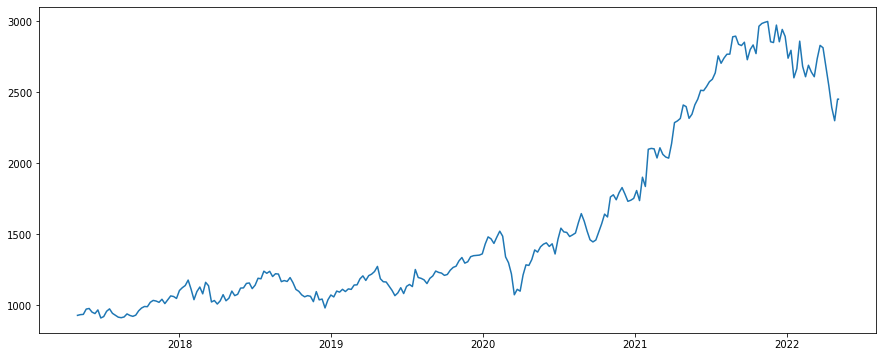

In [34]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)
plt.show()

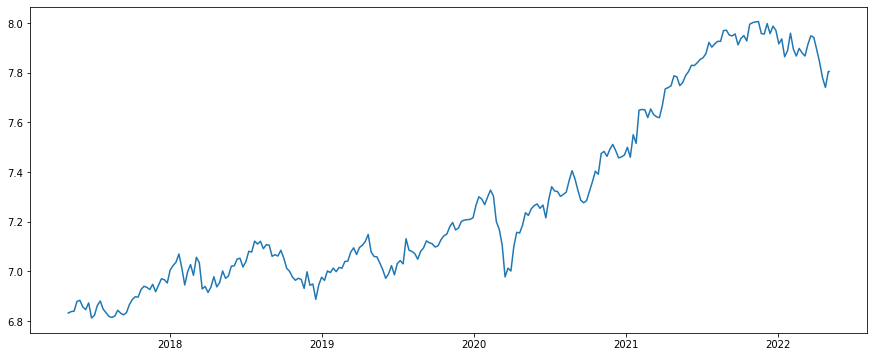

In [35]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

### (3) 시계열 안정성 분석

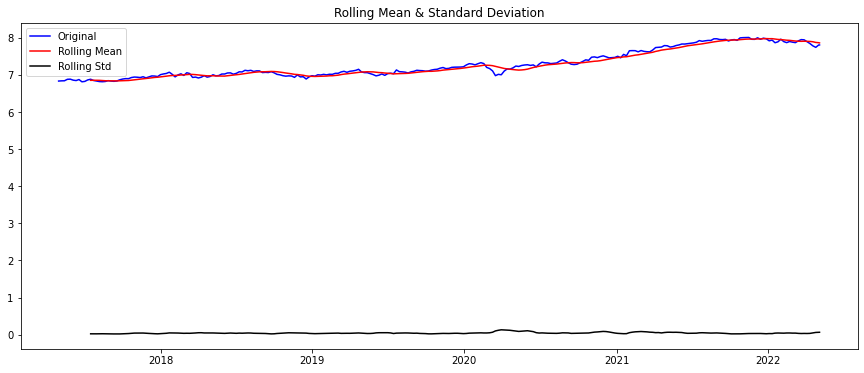

Result of Dickey-Fuller Test:
Test Statistic                  -0.414553
p-value                          0.907640
#Lags Used                       4.000000
Number of Observations Used    258.000000
Ciritical value (1%)            -3.455953
Ciritical value (5%)            -2.872809
Ciritical value (10%)           -2.572775
dtype: float64


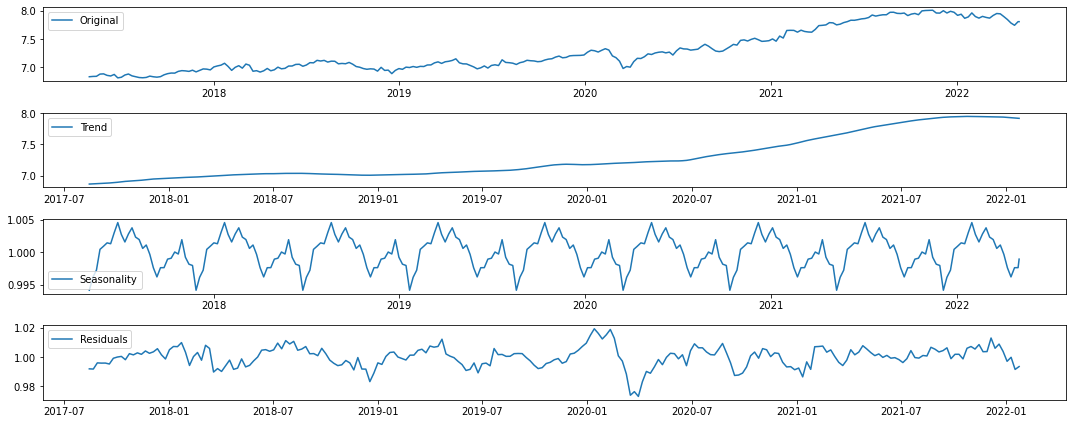

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

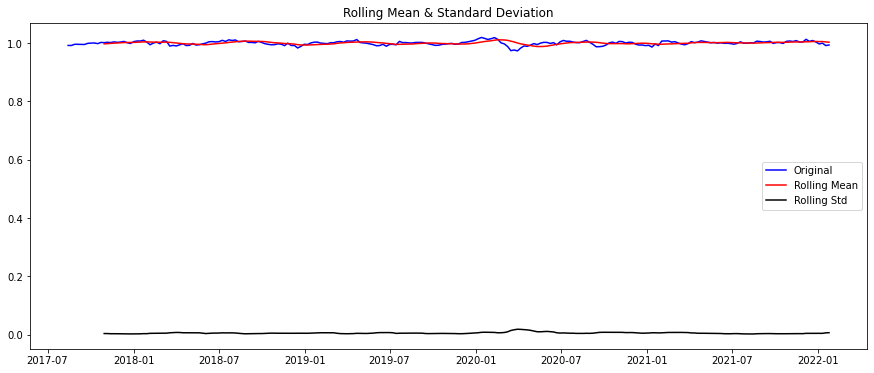

Result of Dickey-Fuller Test:
Test Statistic                -6.122317e+00
p-value                        8.795001e-08
#Lags Used                     3.000000e+00
Number of Observations Used    2.290000e+02
Ciritical value (1%)          -3.459233e+00
Ciritical value (5%)          -2.874245e+00
Ciritical value (10%)         -2.573541e+00
dtype: float64


In [37]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### (4) 학습, 데이터셋 나누기


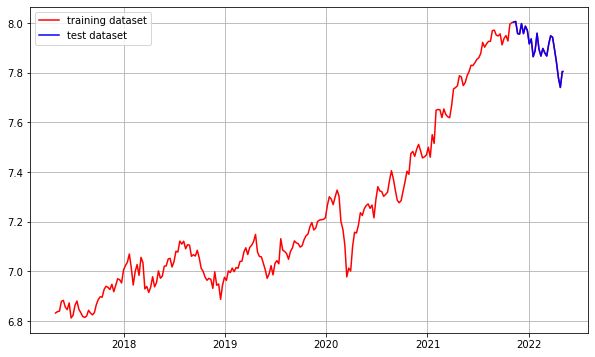

In [38]:

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### (5) 적정 ARIMA 모수 찾기 

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


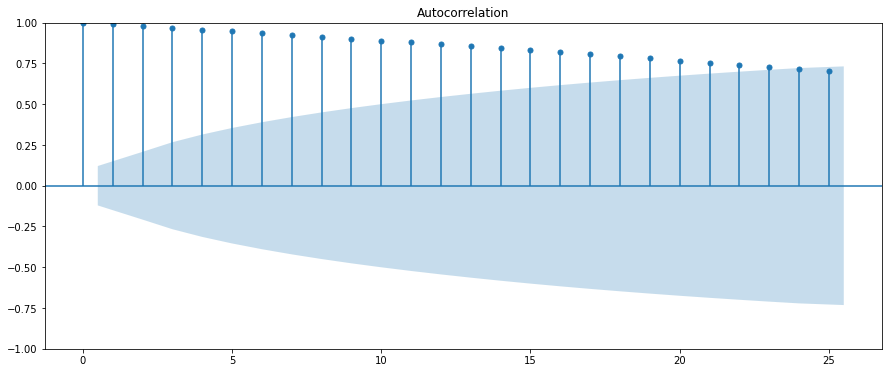

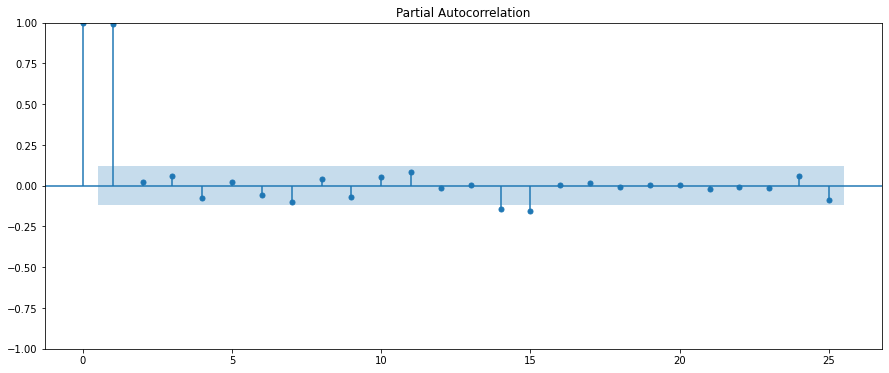

In [39]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Result of Dickey-Fuller Test:
Test Statistic                -8.741972e+00
p-value                        2.991947e-14
#Lags Used                     3.000000e+00
Number of Observations Used    2.580000e+02
Ciritical value (1%)          -3.455953e+00
Ciritical value (5%)          -2.872809e+00
Ciritical value (10%)         -2.572775e+00
dtype: float64


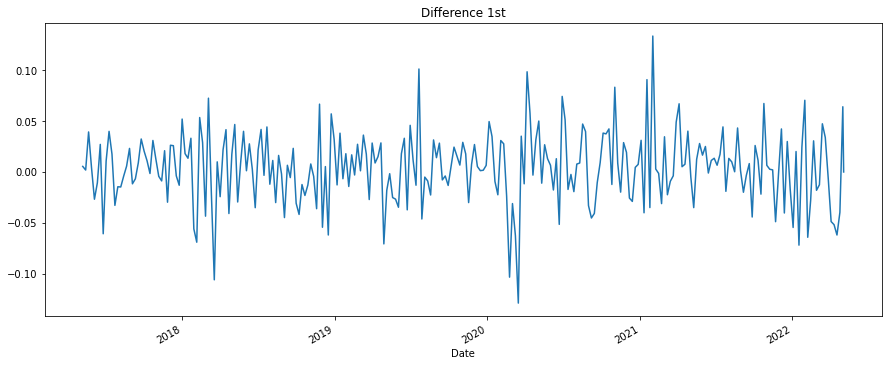

In [40]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### (6) ARIMA 모델 훈련 및 테스트

In [41]:
# Build and Train  Model
# p, d, q
model = ARIMA(train_data, order=(14,0,0))
fitted_m = model.fit()

print('-'*30)

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Max

------------------------------
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  236
Model:                ARIMA(14, 0, 0)   Log Likelihood                 441.867
Date:                Thu, 05 May 2022   AIC                           -851.734
Time:                        14:02:14   BIC                           -796.312
Sample:                    05-01-2017   HQIC                          -829.393
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2957      0.132     55.262      0.000       7.037       7.554
ar.L1          0.7418      0.065     11.336      0.000       0.614       0.870
ar.L2          0.4499

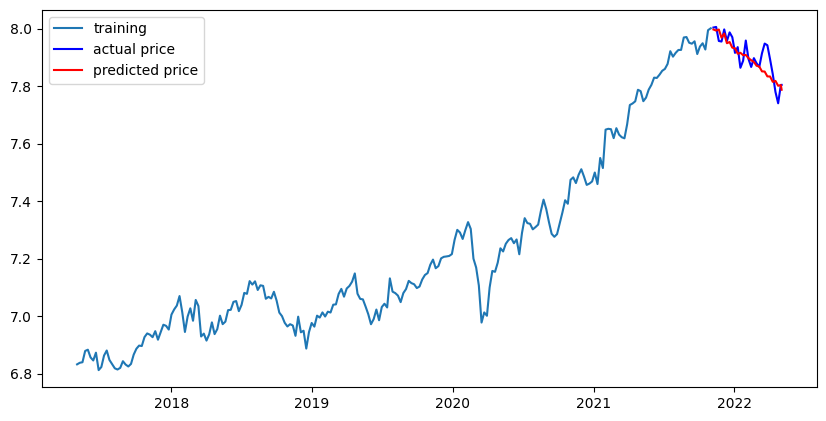

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [43]:
print_score(test_data, fc)

MSE:  12336.410404608449
MAE:  84.09772526173383
RMSE:  111.06939454507011
MAPE: 3.09%


# 회고 

- 삼성전자는 비교적 예측가능한 흐름을 보였고 예측과정에서 MAPE 수치는 1.03% 로 좋은수치가 나왔다

- AT & T 는 2021년 5월 부터 꾸준히 하락새를 보이다 올 초에 잠시 반등하는 듯 하다 떨어지고, 최근 다시 올라가고 있는데, 최근의 하락새는 전쟁과 연관이 있는지 모르겠다.
MAPE 수치는 4.09% 이지만 예측범위가 매우 크게 나온다. 

- 구글은 전체적으로 상승추세를 보이다 코로나를 기점으로 가파르게 상승한 것을 확인 할 수 있고 2022 년에 들어 떨어지는 흐름을 보였는데 코로나와 우크라이나 전쟁과 연관이 있어 보인다. MAPE 은 3.09% 로 좋은 점수가 나왔다



#### 결론 

- 주식가격을 시계열 데이터로 예측을 하기에는 여러가지 요소들에 영향을 받는 것을 확인 할 수 있다. 

- 단순히 시간에 대한 정보 뿐만 아니라 경제적, 정치적, 환경적 요인 등, 여러 수많은 요인이 주식가격에 영향을 미치는 것을 유추할 수 있다. (코로나, 전쟁 등). 동 산업의 주식의 흐름에 대한 정보를 학습한다면 더 나은결과를 도출할 수 있지 않을까 예상한다. 